#  Zombie Detection
Exercise that detects zombies.
 You will use the Object Detection API and retrain RetinaNet to spot Zombies using just 5 training images. You will setup the model to restore pretrained weights and fine tune the classification layers. 




<img src='https://drive.google.com/uc?export=view&id=18Ck0qNSZy9F1KsUKWc4Jv7_x_1e_fXTN' alt='zombie'>

In [1]:
!rm -rf ./models/
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 2426, done.
remote: Counting objects: 100% (2426/2426), done.
remote: Compressing objects: 100% (2025/2025), done.
remote: Total 2426 (delta 581), reused 1387 (delta 373), pack-reused 0
Receiving objects: 100% (2426/2426), 30.79 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (581/581), done.


In [2]:
# install object Detection
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
     |████████████████████████████████| 9.0MB 6.9MB/s 
     |████████████████████████████████| 358kB 51.2MB/s 
     |████████████████████████████████| 1.1MB 45.2MB/s 
     |████████████████████████████████| 2.2MB 47.7MB/s 
     |████████████████████████████████| 829kB 46.1MB/s 
     |████████████████████████████████| 153kB 41.6MB/s 
     |████████████████████████████████| 17.7MB 253kB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 34.7MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 645kB 38.1MB/s 
     |████████████████████████████████| 174kB 39.6MB/s 
     |████████████████████████████████| 706kB 27.6MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 51kB 862kB/s 
     |████████████████████████████████| 112kB 43.0MB/s 
  Created wheel for

In [3]:
#import
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import zipfile
import io
import scipy.misc
import numpy as np
import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [5]:
# import Object Detection API packages
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

In [6]:
#load image and plotting detections.
def load_image_into_numpy_array(path):
  img_data= tf.io.gfile.GFile(path,"rb").read()
  image= Image.open(BytesIO(img_data))
  (im_width,im_height)= image.size
  return np.array(image.getdata()).reshape((im_height,im_width,3)).astype(np.uint8)

In [7]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)



In [8]:
# download the images.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
    -O ./training-zombie.zip

local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()   

--2021-02-18 21:13:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 173.194.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2021-02-18 21:13:15 (144 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


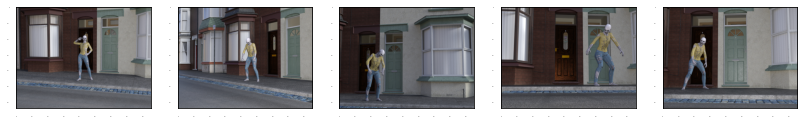

In [11]:
%matplotlib inline
train_image_dir = './training'
train_images_np = []

for i in range(1, 6): 

    image_path = os.path.join(train_image_dir,"training-zombie"+str(i)+".jpg")
    print(image_path)
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [9]:
# Define the list of ground truth boxes
gt_boxes = [] 

In [12]:
# Do the boxes
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [13]:
#look the dimensions
for tg_box in gt_boxes:
  print(tg_box)

[[0.26938889 0.41148886 0.74772222 0.57561547]]
[[0.30105555 0.45603751 0.75772222 0.61781946]]
[[0.41438889 0.16412661 0.94938889 0.35756155]]
[[0.15772222 0.61430246 0.78938889 0.92731536]]
[[0.29772222 0.12309496 0.83438889 0.34935522]]


In [15]:
# define the categoty index dictionary
zombie_class_id= 1 # because is just one object
category_index= {zombie_class_id:{"id":zombie_class_id,
                                  "name":"zombie"}}
num_classes=1

In [16]:
print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


In [17]:

label_id_offset=1 
train_image_tensors=[]
# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  #convert image to tensor, add batch
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
  #convert numpy array to tensor, then add to list
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  # apply offset to to have zero-indexed ground truth classes
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  
  # do one-hot encoding to ground truth classes
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


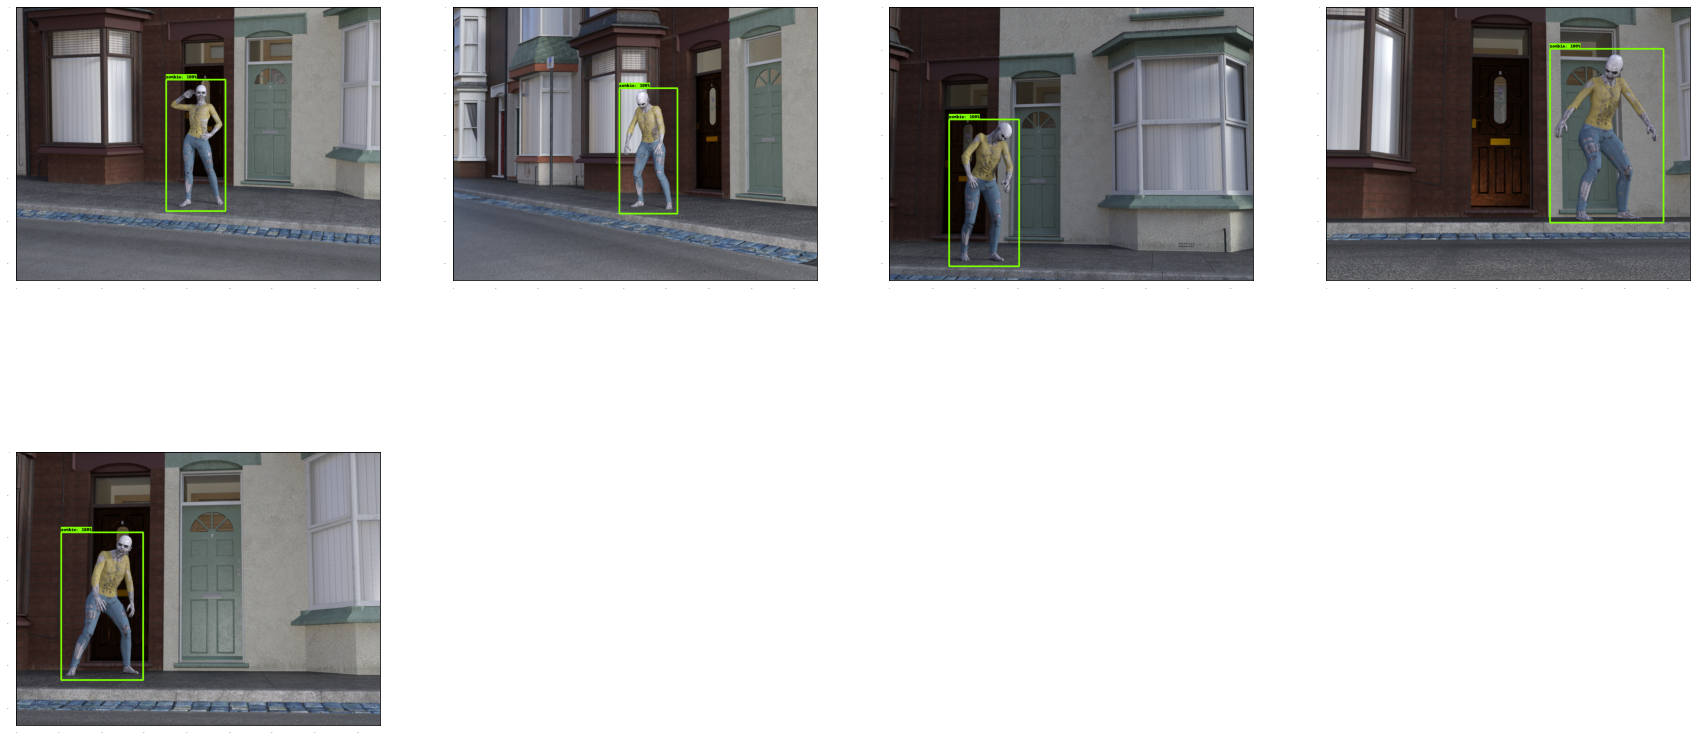

In [18]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

In [19]:
#checkpoints, we will use RETINANET 
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2021-02-18 21:35:55--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   144MB/s    in 1.6s    

2021-02-18 21:35:57 (144 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [20]:
# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [21]:
tf.keras.backend.clear_session()
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
# Load the configuration file into a dictionary
configs =config_util.get_configs_from_pipeline_file(pipeline_config, config_override=None)
# See what configs looks like
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

In [22]:
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs["model"]
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

In [23]:
# change the model
model_config.ssd.num_classes= num_classes
model_config.ssd.freeze_batchnorm=True


In [24]:
# build Model
detection_model = model_builder.build(model_config=model_config,is_training=True)
print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


In [25]:
detection_model

In [26]:
vars(detection_model)

{'_activity_regularizer': None,
 '_add_background_class': True,
 '_add_summaries': True,
 '_anchor_generator': <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator at 0x7fecc6902710>,
 '_anchors': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_batched_prediction_tensor_names': ListWrapper([]),
 '_box_coder': <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder at 0x7fecc6902320>,
 '_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7fecc68f5c18>,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_classification_loss': <object_detection.core.losses.SigmoidFocalClassificationLoss at 0x7fecc690a6d8>,
 '_classification_loss_weight': 1.0,
 '_compute_dtype_object': tf.float32,
 '_default_training_arg': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_equalization_loss_config': EqualizationLossConfig(weight=0.0, exclude_p

In [27]:
detection_model._box_predictor

In [28]:
# you will need these two points
#The base tower layer (the layers the precede both the class prediction and bounding box prediction layers).
#The box prediction head (the prediction layer for bounding boxes)

tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head= detection_model._box_predictor._box_prediction_head, )

In [29]:
# temporart model checkpoint
tmp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=tmp_box_predictor_checkpoint)
    

In [30]:
#restore checkpoint
checkpoint_path = "models/research/object_detection/test_data/checkpoint/ckpt-0"

checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)
# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)

In [31]:
detection_model

In [ ]:
tmp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=tmp_box_predictor_checkpoint)

In [32]:
# use the detection model's `preprocess()` method and pass a dummy image and generate the model variables
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))
# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)
# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict,tmp_shapes)
print('Weights restored!')

Weights restored!


In [33]:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


In [34]:
tf.keras.backend.set_learning_phase(True)

batch_size = 5
num_batches = 100
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [35]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

In [36]:
#"head" refers to the prediction layers.
# define a list that contains the layers that you wish to fine tune

# The bounding box head variables (which predict bounding box coordinates)
# The class head variables (which predict the class/category)

to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for v in detection_model.trainable_variables:
  ji=v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead')
  ja= v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead')
  if ji: 
    to_fine_tune.append(v)
  if ja:
    to_fine_tune.append(v)

In [37]:
#train the Model
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

In [38]:
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [39]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


In [40]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: 'list' object has no attribute 'get_shape'


In [41]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [42]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [43]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [45]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [46]:
# Calculate the loss after you've provided the ground truth 

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.12762593
classification loss 1.12878251


In [47]:
# Let's just reset the model 
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

In [48]:
# decorate with @tf.function for faster training
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_image_list = []
      true_shape_list = []

      for img in image_list:
        processed_img, true_shape = model.preprocess(img)
        preprocessed_image_list.append(processed_img)
        true_shape_list.append(true_shape)
    
      preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
      true_shape_tensor = tf.concat(true_shape_list, axis=0)

      prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)
      losses_dict = model.loss(prediction_dict, true_shape_tensor)
        
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
      gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        ### END CODE HERE ###
        
    return total_loss

In [49]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune)
                              

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.2080535
batch 10 of 100, loss=16.964352
batch 20 of 100, loss=10.567432
batch 30 of 100, loss=1.0340407
batch 40 of 100, loss=0.34942767
batch 50 of 100, loss=0.14212
batch 60 of 100, loss=0.07616952
batch 70 of 100, loss=0.039673086
batch 80 of 100, loss=0.014826767
batch 90 of 100, loss=0.0010453028
Done fine-tuning!


In [51]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

--2021-02-18 23:50:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   206MB/s    in 0.4s    

2021-02-18 23:50:52 (206 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



In [52]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

In [53]:
@tf.function
def detect(input_tensor):
  
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

In [54]:

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [55]:

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


In [56]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

97.8902953586498


Frame 0


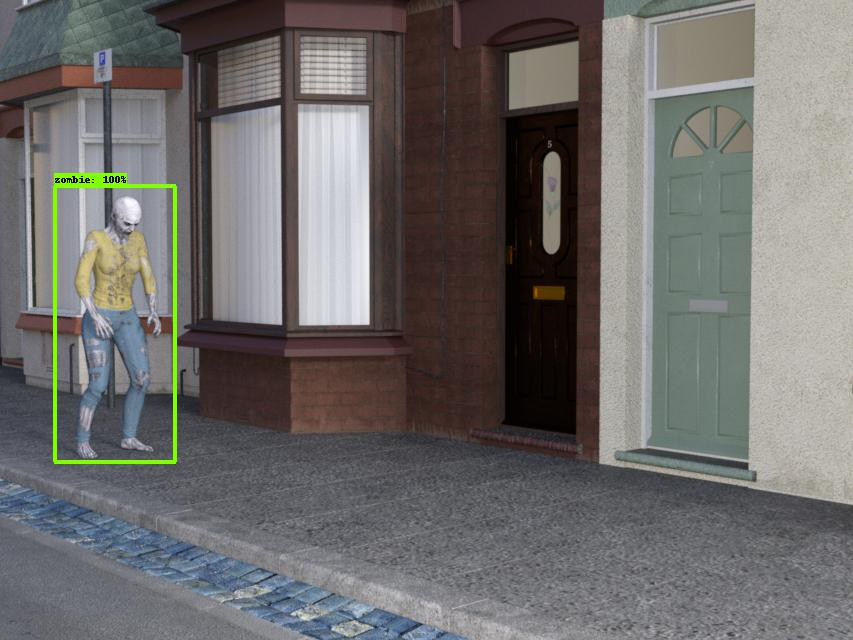


Frame 5


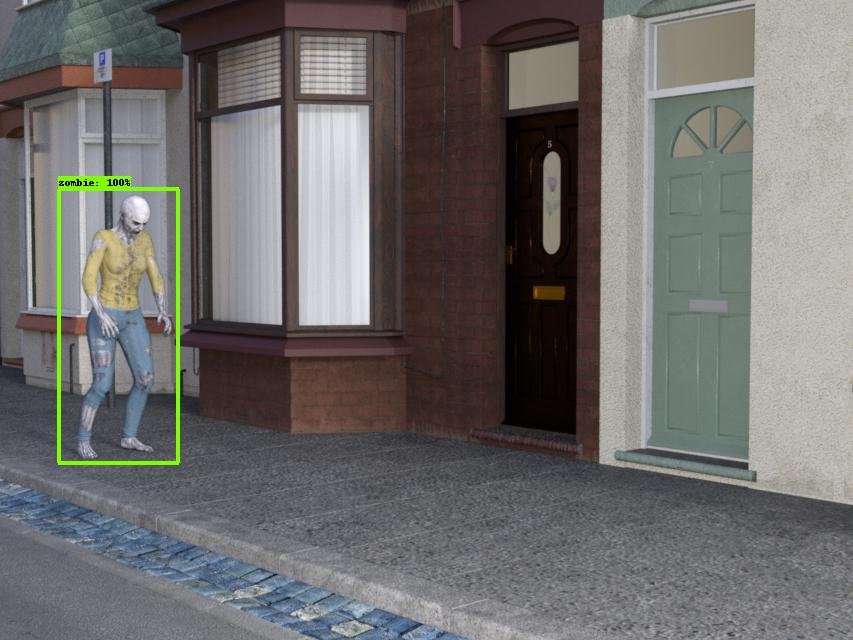


Frame 10


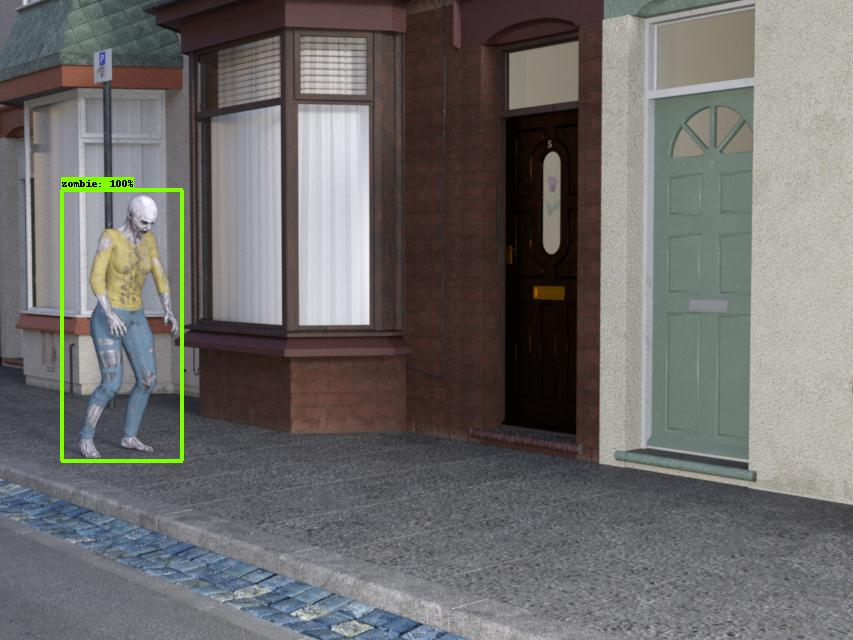

In [57]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

In [58]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

In [59]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10) 

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)1458176/4830080 bytes (30.2%)3997696/4830080 bytes (82.8%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
